In [ ]:
from src.utils.compute_transition_matrix import compute_transition_matrix
from src.core.LangevinGillespie import LangevinGillespie
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import math
import time

In [71]:
# Simulation Setup
LG = LangevinGillespie()
LG.steps = 2000
LG.dt = 1e-6
LG.method = "heun"

# Mechanical / Thermal Setup
LG.kappa = 56
LG.kBT = 4.14
LG.gammaB = LG.computeGammaB(a=20, r=19, eta=1e-9)

# Multi State Setup
LG.theta_states = np.array([3, 36, 72, 116]) * math.pi / 180  # Deg → Rad
LG.initial_state = 0  # Starting state

# Transition rate matrix
LG.transition_matrix = compute_transition_matrix(LG)

In [72]:
def compute_simulation_time(n_steps, rng_seed=None):
    """Run a simulation with n_steps and return elapsed time in seconds."""
    LG.steps = n_steps
    start_time = time.time()
    LG.simulate(rng=rng_seed)
    return time.time() - start_time


Running simulations...

Average simulation time: 0.0384 seconds
Number of simulations run: 20
Step range: 500 to 10000 steps


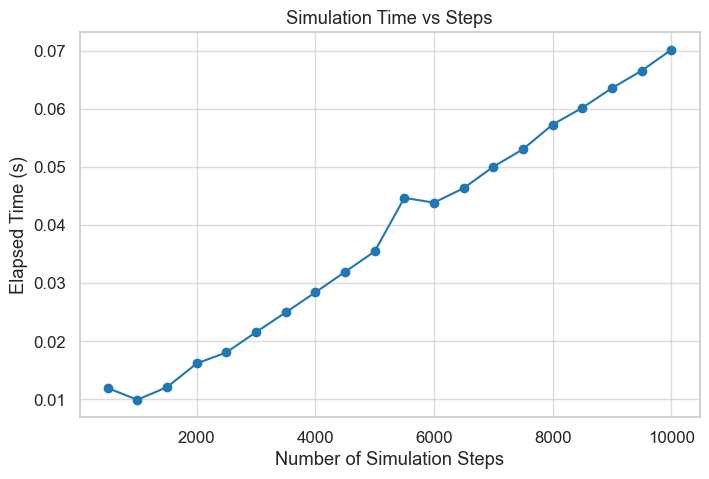

In [73]:
MAX_STEPS = 10_000
STEP_INTERVAL = 500

step_counts = list(range(500, MAX_STEPS + 1, STEP_INTERVAL))
times = []

print("Running simulations...")
for steps in step_counts:
    elapsed = compute_simulation_time(steps, rng_seed=42)
    times.append(elapsed)

# Calculate and print average time
average_time = np.mean(times)
print(f"\nAverage simulation time: {average_time:.4f} seconds")
print(f"Number of simulations run: {len(step_counts)}")
print(f"Step range: {step_counts[0]} to {step_counts[-1]} steps")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(step_counts, times, marker="o", linestyle="-", color="tab:blue")
plt.xlabel("Number of Simulation Steps")
plt.ylabel("Elapsed Time (s)")
plt.title("Simulation Time vs Steps")
plt.grid(True, alpha=0.7)
plt.show()